In [1]:
%load_ext autoreload
%autoreload 2
import sys
from scipy.fftpack import dctn, idctn
from scipy.ndimage import zoom

sys.path.append("..")
from src import *

Cupy Available= 1


In [ ]:
size=8
imgs=[]
for i in trange(size):
    for j in range(size):
        dct=np.zeros((size,size))
        dct[i,j]=1
        imgs.append(idctn(dct))
imshow(imgs, cols=size, size=4,vrange=(-3,3), path="dcts.png", cmap="viridis")

In [136]:
size=4
idct_3d=[]
for i in trange(size):
    for j in range(size):
        for k in range(size):
            dct=np.zeros((size,size,size))
            dct[i,j,k]=1
            idct_3d.append(idctn(dct))

100%|██████████| 4/4 [00:00<00:00, 4477.51it/s]


In [ ]:
zoom_factor = 8
order = 0
cmap = "viridis"

x1, x2, x3 = np.meshgrid(
    np.arange(size * zoom_factor), np.arange(size * zoom_factor), np.arange(size * zoom_factor), indexing="ij"
)
for z in range(size):
    fig, axs = plt.subplots(size, size, subplot_kw={"projection": "3d"}, figsize=(14, 14))
    for i in range(size):
        for j in range(size):
            ax = axs[i, j]
            ax.scatter(
                x1,
                x2,
                x3,
                c=zoom(idct_3d[z * size**2 + i * size + j], zoom_factor, order=order),
                cmap=cmap,
                s=10_000 / (size * zoom_factor) ** 2,
                alpha=0.2,
            )
            ax.grid(False)
            ax.set_axis_off()
            ax.view_init(elev=30, azim=45)
    plt.tight_layout()
    plt.show()

### Mask

In [49]:
patch_xy = 128
frames_per_patch = 128
s0 = 8
δ_s = 24
t0 = 0
δ_t = 64

W_s = np.clip(
    (np.sqrt(np.arange(patch_xy)[None, :] ** 2 + np.arange(patch_xy)[:, None] ** 2) - (s0 - δ_s)) / (2 * δ_s), 0, 1
)
W_t = 1 - np.clip((np.arange(frames_per_patch) - (t0 - δ_t)) / (2 * δ_t), 0, 1)
W = (W_s[:, :, None] * W_t).transpose(2,0,1)

100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


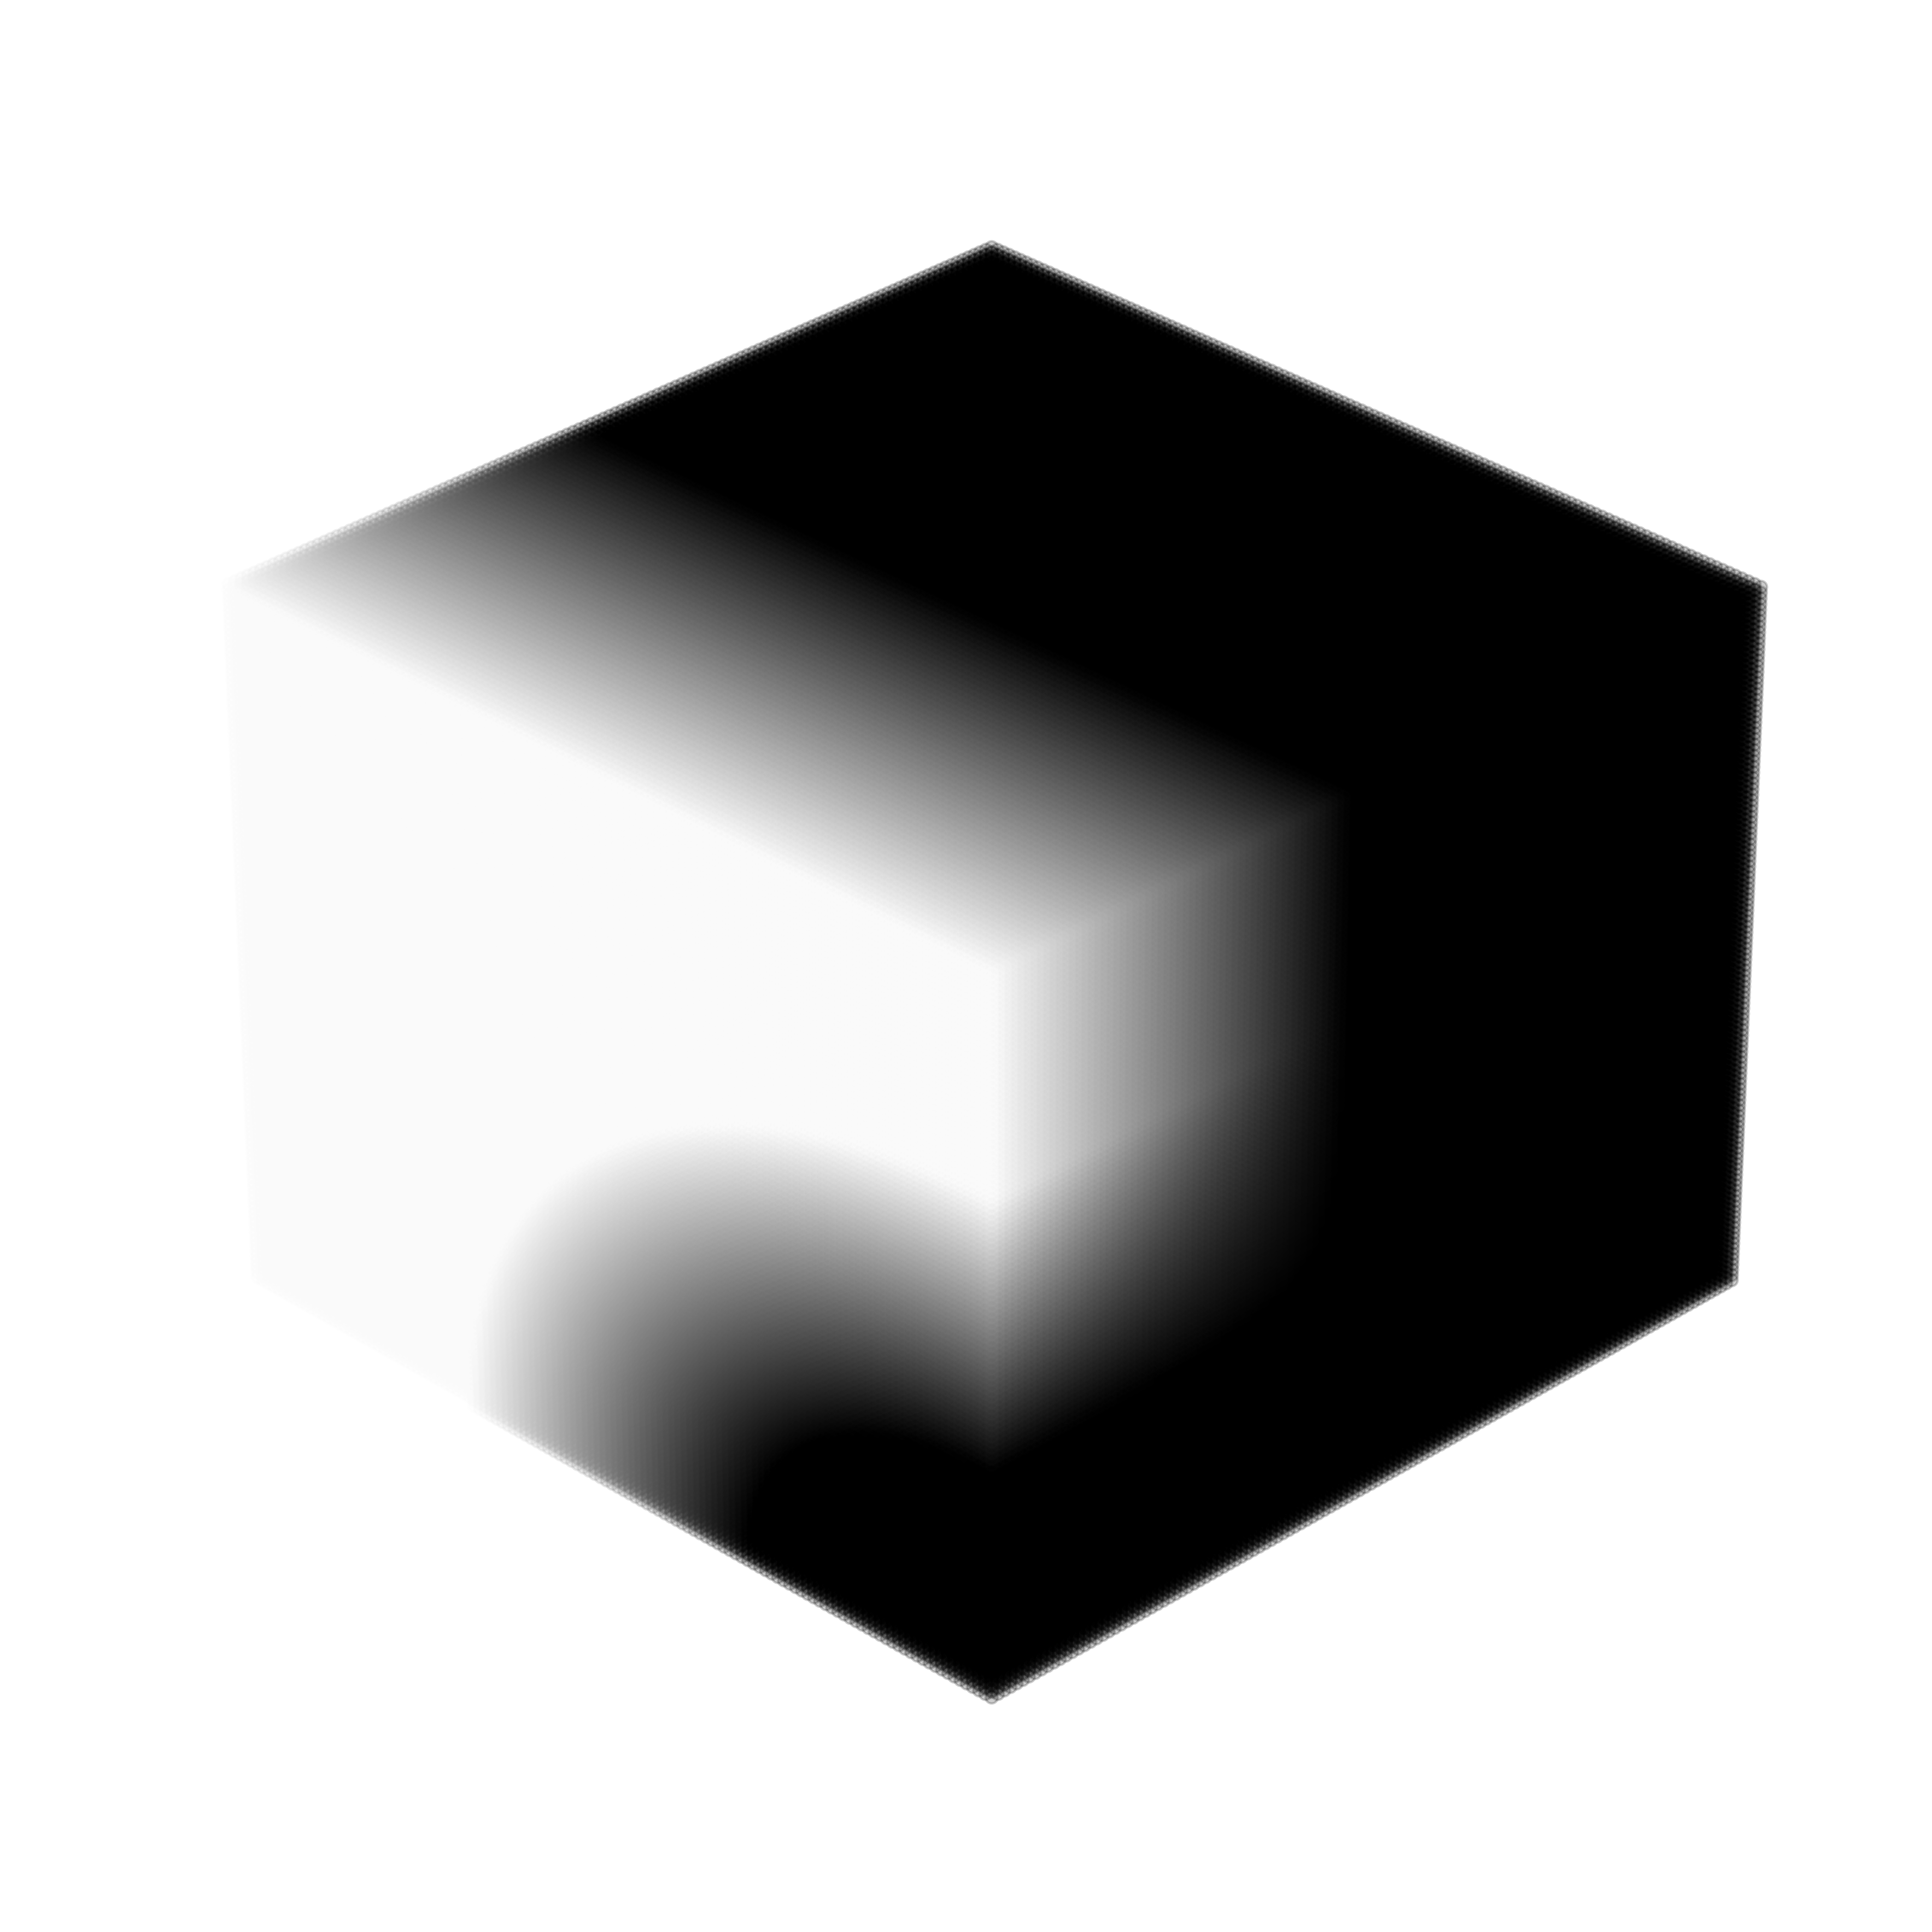

In [56]:
zoom_factor = 1/2
order = 0
cmap = "grey"

fig, axs = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(12, 12), dpi=300)
for i, (s0, δs, t0, δt) in enumerate(
    tqdm(
        [
            # (8, 24, 0, 64),
            # (16, 64, 0, 32),
            # (48, 128, -6, 16),
            (64, 196, -6, 32),
            # (64, 128, -6, 16),
            # (128, 64, -6, 16),
            # (64, 128, -6, 32),
            # (128, 64, -6, 32),
            # (48, 96, -6, 16),
            # (48, 96, 0, 4),
            # (36, 72, -6, 16),
            # (36, 72, -6, 8),
        ]
    )
):
    W_s = np.clip(
        (np.sqrt(np.arange(patch_xy)[None, :] ** 2 + np.arange(patch_xy)[:, None] ** 2) - (s0 - δ_s)) / (2 * δ_s), 0, 1
    )
    W_t = 1 - np.clip((np.arange(frames_per_patch) - (t0 - δ_t)) / (2 * δ_t), 0, 1)
    W = (W_s[:, :, None] * W_t).transpose(2, 0, 1)

    x1, x2, x3 = np.meshgrid(
        np.arange(frames_per_patch * zoom_factor),
        np.arange(patch_xy * zoom_factor),
        np.arange(patch_xy * zoom_factor),
        indexing="ij",
    )
    # ax = axs[i//4][i%4]
    ax=axs
    ax.scatter(
        x1,
        x2,
        x3,
        c=zoom(W, zoom_factor, order=order),
        cmap=cmap,
        s=30,
        alpha=0.2,
    )
    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45+180)
plt.tight_layout()
plt.show()

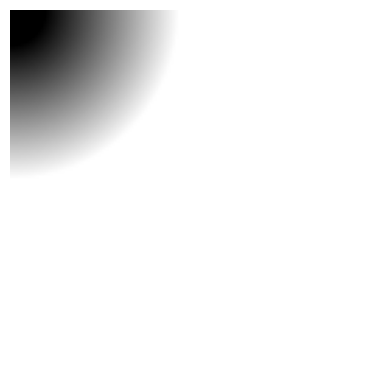

In [51]:
imshow(W[0])

# Exploring DCT

In [113]:
patch_xy = 512
frames_per_patch = 64
dataset = NoisyDataset(
    "oabf_astro",
    patch_xy=patch_xy,
    frames_per_patch=frames_per_patch,
    augument=False,
    max_frames=128,
    overlap=0,
    verbose=True,
)

The dataset has 1z x 1y x 1x = 1 samples


In [114]:
i = np.random.randint(len(dataset))
even, odd = dataset[i]
patch = even.numpy()[0]

0 --> [0:128 z, 0:512 y, 0:512 x]


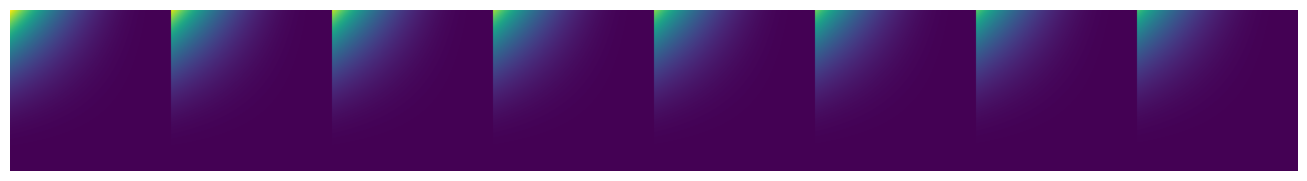

(64, 512, 512)

In [181]:
size = patch_xy
k = size - np.arange(size)
k = k.reshape(-1, 1, 1) * k.reshape(1, -1, 1) * k.reshape(1, 1, -1)
k = k[:frames_per_patch]
k = k / np.max(k)
k = k**3

imshow(np.concatenate([_ for _ in k[::8]], axis=1), size=18)
k.shape

In [182]:
patch_dct = dctn(patch, type=2, norm="ortho")
patch_idct = idctn(patch_dct, type=2, norm="ortho")
patch_denoised=idctn(patch_dct*k, type=2, norm="ortho")

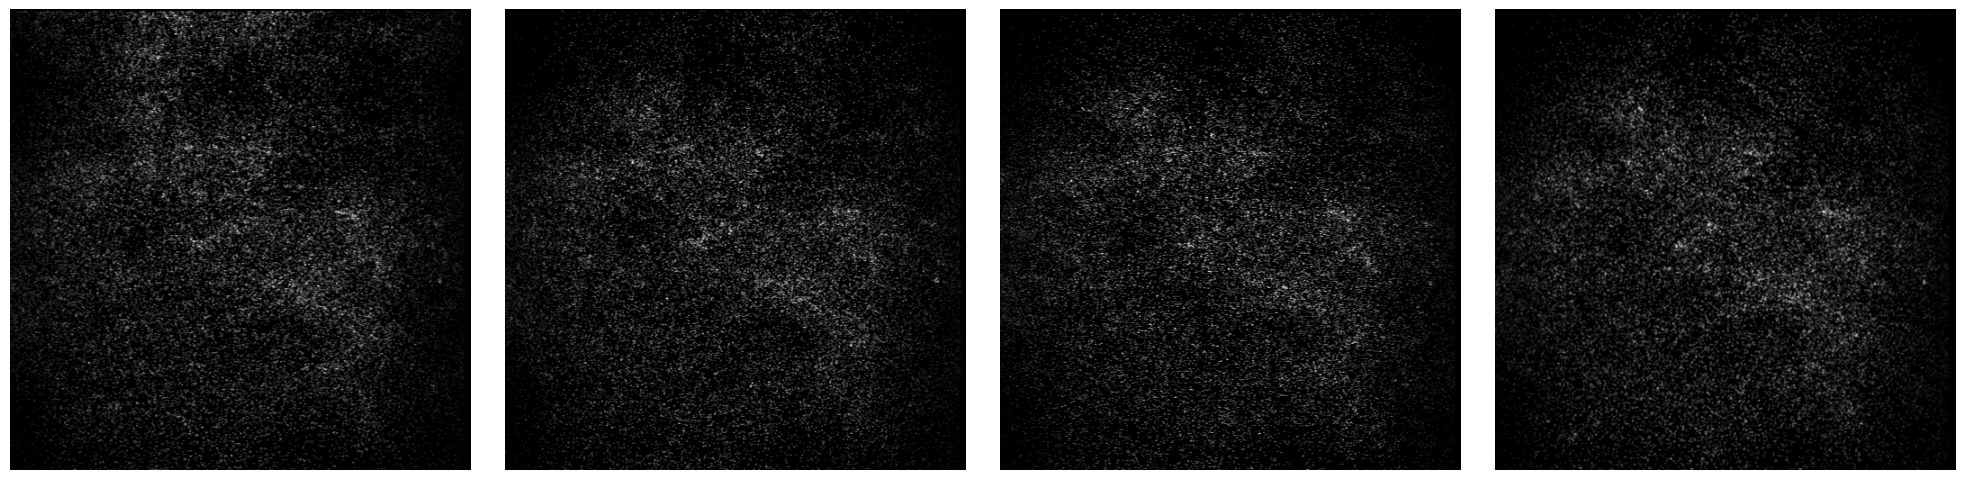

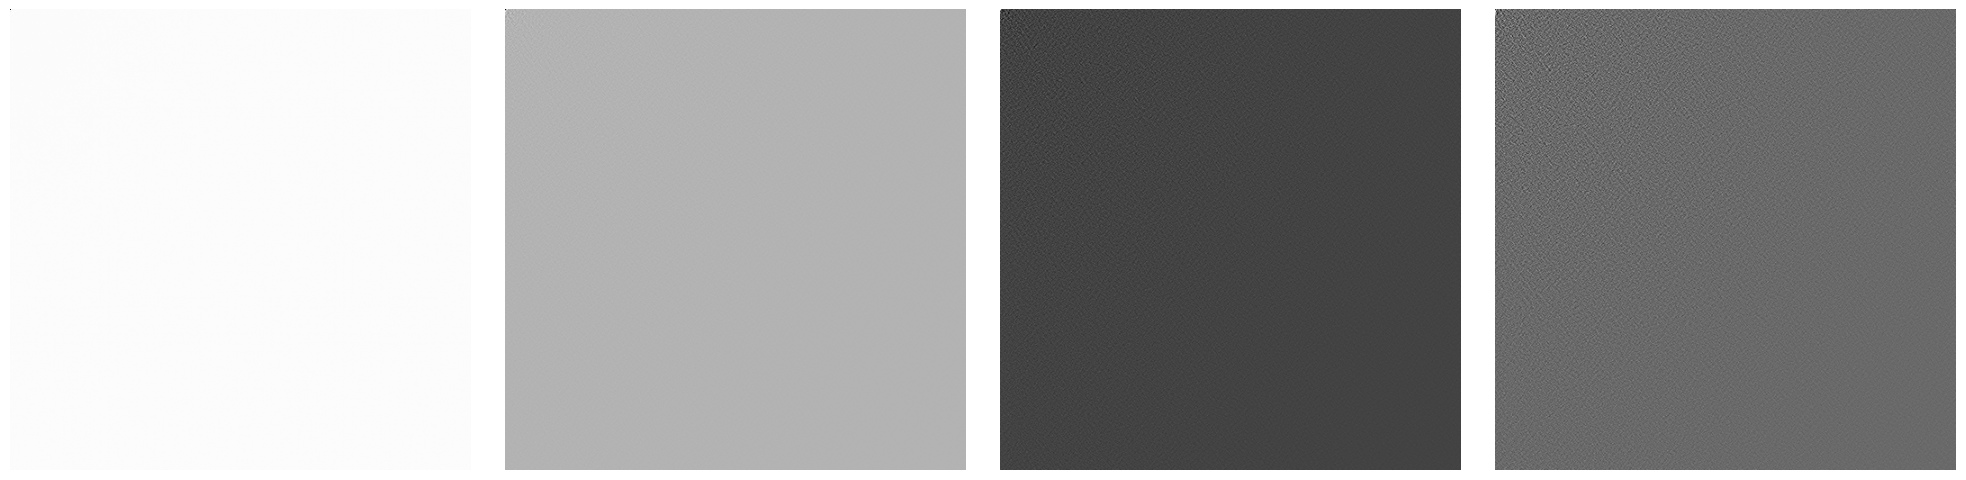

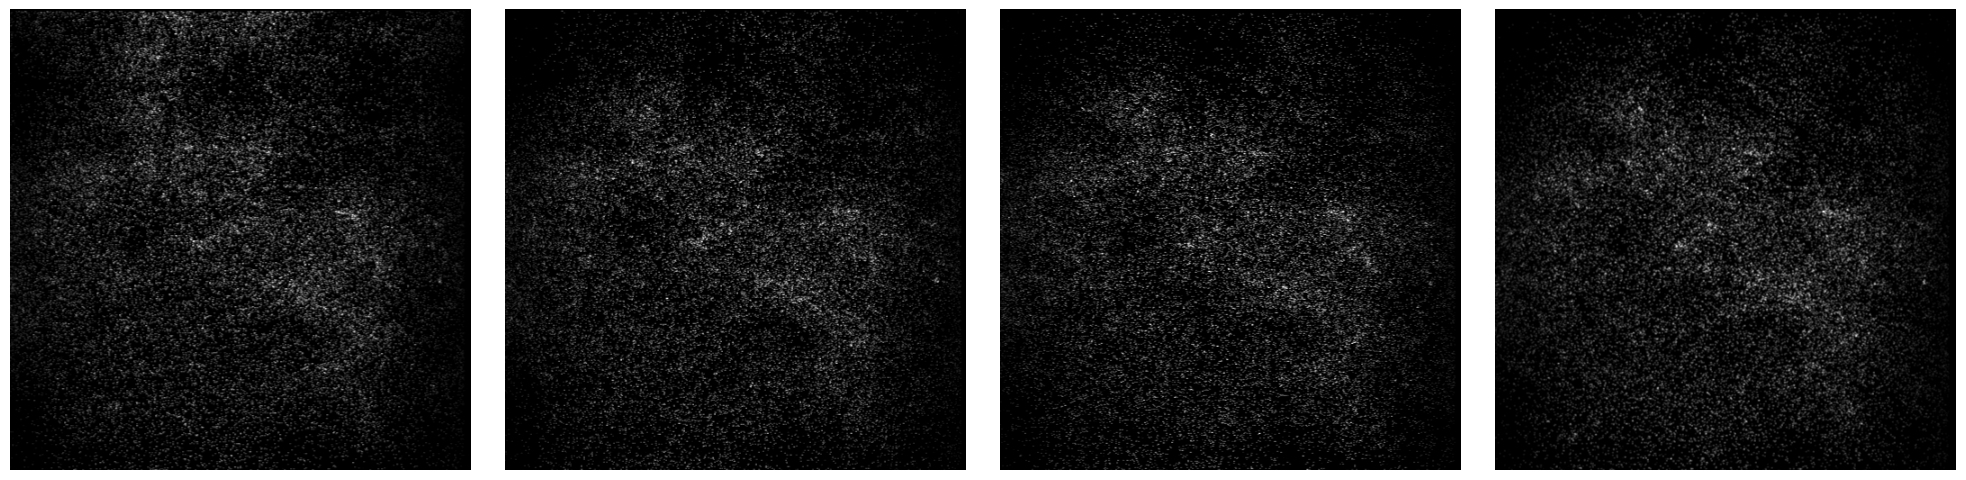

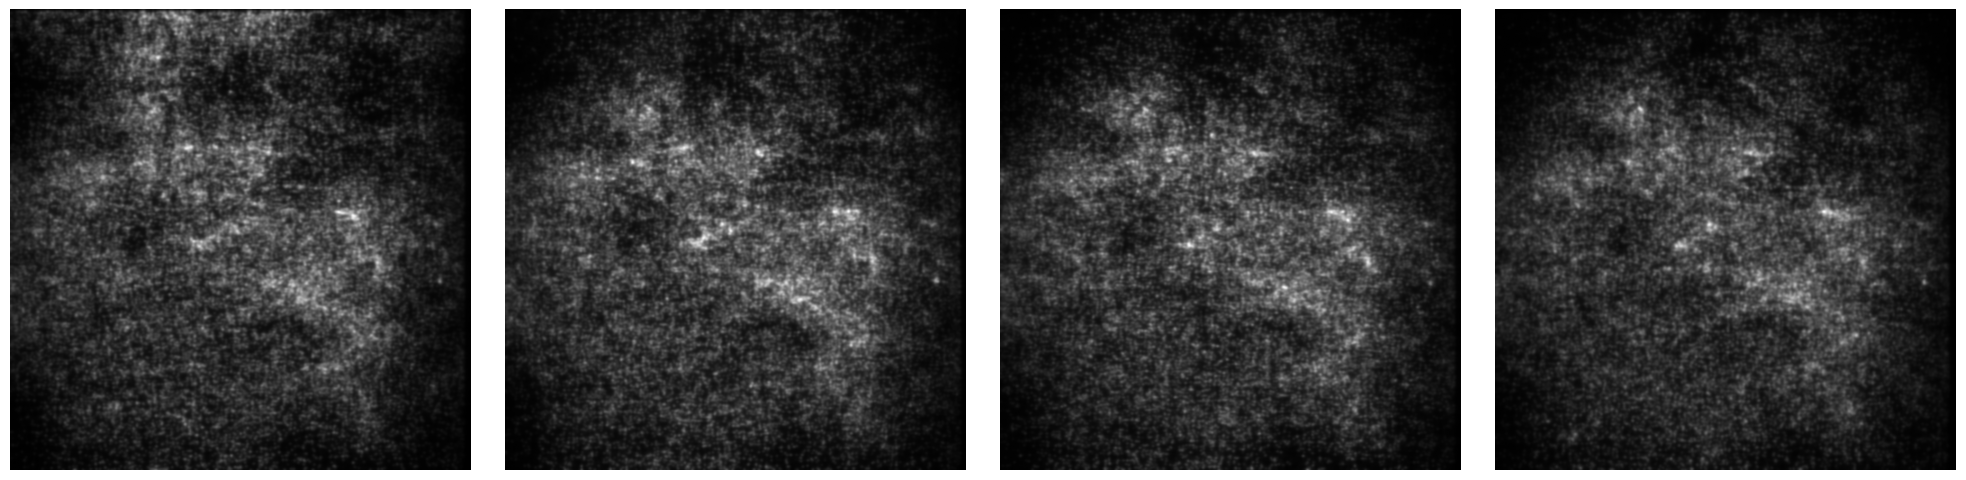

In [185]:
max_frames=4
imshow([_ for _ in patch[:max_frames]], cmap="grey",size=5, cols=max_frames)
imshow([_ for _ in patch_dct[:max_frames]], cmap="grey",size=5, cols=max_frames)
imshow([_ for _ in patch_idct[:max_frames]], cmap="grey",size=5, cols=max_frames)
imshow([_ for _ in patch_denoised[:max_frames]], cmap="grey",size=5, cols=max_frames)
